In [1]:
import json
import os
from pathlib import Path
import sys
import time

from IPython.display import display
import joblib
from matplotlib.ticker import MultipleLocator
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.ensemble
import sklearn.feature_selection
import sklearn.metrics
import sklearn.model_selection
from tqdm.auto import tqdm

from run import filepath_x, filepath_y, filepath_s, filepath_performance_folds, filepath_outer_folds

X = pd.read_pickle(filepath_x)
y = pd.read_pickle(filepath_y)
s = pd.read_pickle(filepath_s)
outer_folds = joblib.load(filepath_outer_folds)

# Determine best parameters 
Determine for every value of orthogonality and for every outer fold

In [10]:
best_params = (
    pd.read_pickle(filepath_performance_folds)
    .groupby(['orthogonality', 'outer_fold', 'max_depth', 'n_bins'], as_index=False)
    .agg({'auc_y': 'mean', 'auc_s': 'mean'})
    .sort_values('auc_y', ascending=False)
    .drop_duplicates(subset=['orthogonality', 'outer_fold'])
    .sort_values(['orthogonality', 'outer_fold'])
    [['orthogonality', 'outer_fold', 'max_depth', 'n_bins']]
)

In [11]:
best_params

,orthogonality,outer_fold,max_depth,n_bins
5,0.0,0,6,2
15,0.0,1,6,2
25,0.0,2,6,2
35,0.0,3,6,2
45,0.0,4,6,2


# Measure total performance

In [12]:
total_performance_before_aggregation = list()
for p in tqdm(list(best_params.itertuples())):
    y_score = np.load(f'models/outer_folds/{p.max_depth}-{p.orthogonality:.2f}-{p.n_bins}-{p.outer_fold}.npy')
    
    _, (_, test_idx) = outer_folds[p.outer_fold]
    y_test = y[test_idx]
    s_test = s[test_idx]
    auc_y = sklearn.metrics.roc_auc_score(y_test, y_score)
    auc_s = sklearn.metrics.roc_auc_score(s_test, y_score)
    auc_s = max(auc_s, 1-auc_s)    
    
    total_performance_before_aggregation.append(
        dict(orthogonality=p.orthogonality, auc_y=auc_y, auc_s=auc_s, 
             fold=p.outer_fold)
    )
total_performance_before_aggregation = pd.DataFrame(total_performance_before_aggregation)
total_performance = (
    total_performance_before_aggregation
    .groupby(['orthogonality'])
    .agg(auc_y=('auc_y', 'mean'), auc_y_std=('auc_y', 'std'),
         auc_s=('auc_s', 'mean'), auc_s_std=('auc_s', 'std'))
)

  0%|          | 0/5 [00:00<?, ?it/s]

In [13]:
total_performance

,auc_y,auc_y_std,auc_s,auc_s_std
orthogonality,,,,
0.0,0.814402,0.00385,0.626898,0.013815


# Determine $\hat y$ and threshold

In [14]:
iterator = list(best_params.itertuples())

y_scores_all = list()
y_test_all = list()
s_test_all = list()
for p in tqdm(iterator): 
    y_score = np.load(f'models/outer_folds/{p.max_depth}-{p.orthogonality:.2f}-{p.n_bins}-{p.outer_fold}.npy')
    
    _, (_, test_idx) = outer_folds[p.outer_fold]
    
    y_test = y[test_idx]
    s_test = s[test_idx]
    
    # FLIPPING!!!
    y_scores_all.extend(1-y_score)
    y_test_all.extend(~y_test)
    
    s_test_all.extend(s_test)
    
y_scores_all = np.array(y_scores_all)
y_test_all = np.array(y_test_all)
s_test_all = np.array(s_test_all)

threshold = np.quantile(y_scores_all, np.mean(~y_test_all))
y_pred_all = y_scores_all > threshold

np.save('cache/y_score_randomforest.npy', y_scores_all)
np.save('cache/y_true_randomforest.npy', y_test_all)
np.save('cache/s_randomforest.npy', s_test_all)

  0%|          | 0/5 [00:00<?, ?it/s]

Text(0, 0.5, '$P(x > Z)$')

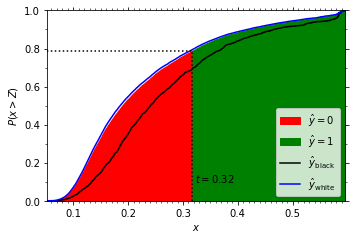

In [15]:
fig, ax = plt.subplots(figsize=(4.82,4.82*(2/3)), constrained_layout=True)
y_scores_sorted = np.sort(y_scores_all)
y1 = 1. * np.arange(len(y_scores_sorted)) / (len(y_scores_sorted) - 1)
y_scores_sorted_b = np.sort(y_scores_all[s_test_all])
y2 = 1. * np.arange(len(y_scores_sorted_b)) / (len(y_scores_sorted_b) - 1)
y_scores_sorted_w = np.sort(y_scores_all[~s_test_all])
y3 = 1. * np.arange(len(y_scores_sorted_w)) / (len(y_scores_sorted_w) - 1)

threshold_idx = np.argmax(np.sort(y_scores_all) > threshold)
ax.text(threshold+.005, .1, rf"$t={threshold:.02}$")
ax.fill_between(y_scores_sorted[:threshold_idx], y1[:threshold_idx], color='red', label=r'$\^y = 0$')
ax.fill_between(y_scores_sorted[threshold_idx:], y1[threshold_idx:], color='green', label=r'$\^y = 1$')
ax.plot(y_scores_sorted_b, y2, color='black', label=r'$\^y_\mathrm{black}$')
ax.plot(y_scores_sorted_w, y3, color='blue', label=r'$\^y_\mathrm{white}$')

ax.vlines(threshold, 0, y1[threshold_idx], color='black', ls=':')
ax.hlines(y1[threshold_idx], 0, threshold, color='black', ls=':')
ax.legend(loc='lower right')
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_minor_locator(MultipleLocator(.01))
ax.yaxis.set_minor_locator(MultipleLocator(.1))
ax.set_xlim(y_scores_sorted[0], y_scores_sorted[-1])
ax.set_ylim(0, 1)
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$P(x > Z)$')
# fig.savefig('fig/score-cdf.pdf')

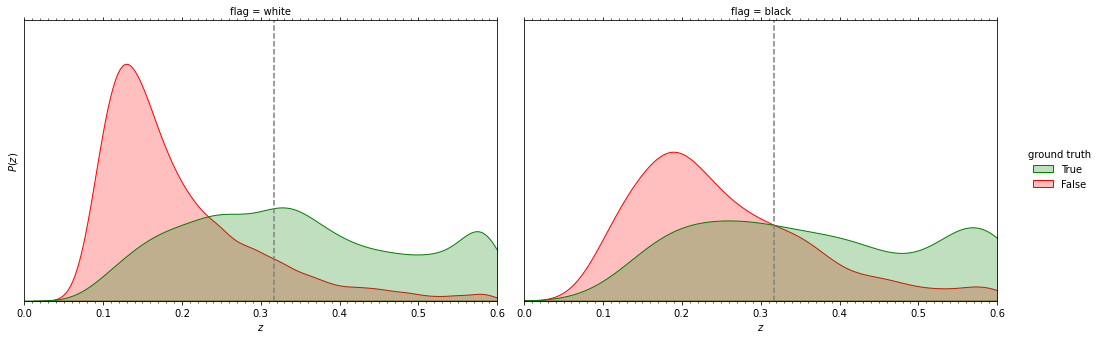

In [16]:
data_ = pd.DataFrame({'x': y_scores_all, 'ground truth': y_test_all, 'flag': np.where(s_test_all, 'black', 'white')})
g = sns.displot(
    data=data_, x='x', hue='ground truth', col='flag', kind='kde', hue_order=[True, False], palette=['green', 'red'], common_norm=False, fill=True, height=4.82, aspect=3/2, 
    facet_kws={'despine': False, 'xlim': (0, .6)}
)
# sns.despine(top=False, right=False)
g.refline(x=threshold)
g.set_axis_labels(r'$z$', r'$P(z)$')
g.set_yticklabels([])
g.set(yticks=[])
g.axes[0][0].xaxis.set_minor_locator(MultipleLocator(.01))
g.axes[0][0].xaxis.set_ticks_position('both')
g.axes[0][1].xaxis.set_ticks_position('both')
# plt.savefig('fig/score-pdf.pdf')

In [17]:
y = y_test_all
s = s_test_all
y_score = y_pred_all

data = np.concatenate(
    (
        sklearn.metrics.confusion_matrix(y[s], y_score[s], normalize=None)[:2, :], 
        sklearn.metrics.confusion_matrix(y[~s], y_score[~s], normalize=None)[:2, :]
    ),
)

df = pd.DataFrame(
    data, 
    index=pd.MultiIndex.from_product([['Non-white', 'White'], ['Non-compliant', 'Compliant']], names=['Flag', 'True']),
    columns=['Non-compliant', 'Compliant']
)
df = (
    df
    .reset_index()
    .melt(id_vars=['Flag', 'True'], var_name='Predicted', value_name='Number')
)
df['Model'] = 'Random Forest'
display(df)
df.to_pickle('cache/confusion-matrix-random-forest.pkl')

,Flag,True,Predicted,Number,Model
0,Non-white,Non-compliant,Non-compliant,1007,Random Forest
1,Non-white,Compliant,Non-compliant,115,Random Forest
2,White,Non-compliant,Non-compliant,16683,Random Forest
3,White,Compliant,Non-compliant,2348,Random Forest
4,Non-white,Non-compliant,Compliant,327,Random Forest
5,Non-white,Compliant,Compliant,164,Random Forest
6,White,Non-compliant,Compliant,2136,Random Forest
7,White,Compliant,Compliant,2794,Random Forest


In [18]:
np.bincount(y)

array([20153,  5421])

In [19]:
objs = [
    pd.crosstab(
        pd.Series(y_test_all[s_test_all ], name='Inspection outcome').replace({True: 'Compliant', False: 'Non-compliant'}), 
        pd.Series(y_pred_all[s_test_all ], name='Predicted'         ).replace({True: 'Compliant', False: 'Non-compliant'})
    ),
    pd.crosstab(
        pd.Series(y_test_all[~s_test_all], name='Inspection outcome').replace({True: 'Compliant', False: 'Non-compliant'}), 
        pd.Series(y_pred_all[~s_test_all], name='Predicted'         ).replace({True: 'Compliant', False: 'Non-compliant'})
    )
]
pd.concat(objs, axis=1, keys=['black', 'white'], names=['flag'])

flag                   black                   white              
Predicted          Compliant Non-compliant Compliant Non-compliant
Inspection outcome                                                
Compliant                164           115      2794          2348
Non-compliant            327          1007      2136         16683

# Determine fairness measures with prior threshold

In [20]:
values = (0,)
iterator = [(ortho, fold) for ortho in values for fold in range(5)]

y_scores_all = {np.around(orthogonality, 1): [] for orthogonality in values}
y_test_all = {np.around(orthogonality, 1): [] for orthogonality in values}
s_test_all = {np.around(orthogonality, 1): [] for orthogonality in values}
y_pred_all = {np.around(orthogonality, 1): [] for orthogonality in values}
fairness_measures = list()

for ortho, fold in tqdm(iterator):  
    best_params_ = best_params.loc[lambda x: (x.orthogonality.round(1) == ortho) & (x.outer_fold == fold)].iloc[0]
    max_depth = int(best_params_['max_depth'])
    n_bins = int(best_params_['n_bins'])
    filepath = f'models/outer_folds/{max_depth}-{ortho:.2f}-{n_bins}-{fold}.npy'
    y_score = np.load(filepath)
    
    _, (_, test_idx) = outer_folds[fold]
    assert len(y_score) == len(test_idx)
    
    y_test = y[test_idx]
    s_test = s[test_idx]
    
    # FLIPPING!!!
    y_scores_all[ortho].extend(1-y_score)
    y_test_all[ortho].extend(~y_test)
    s_test_all[ortho].extend(s_test)

for ortho in values:
    y_score = np.array(y_scores_all[ortho])
    y_test = np.array(y_test_all[ortho])
    s_test = np.array(s_test_all[ortho])
    threshold = np.quantile(y_scores_all[ortho], np.mean(~y_test))

    y_pred = y_score > threshold
    ppr_w = y_pred[~s_test].mean()
    ppr_b = y_pred[s_test].mean()

    fpr_w = (y_score > threshold)[~y_test & ~s_test].mean()
    fpr_b = (y_score > threshold)[~y_test & s_test].mean()
    tpr_w = (y_score > threshold)[y_test & ~s_test].mean()
    tpr_b = (y_score > threshold)[y_test & s_test].mean()

    fairness_measures.append(
        {
            'orthogonality': ortho,
            'positive prediction rate (white)': ppr_w,
            'positive prediction rate (black)': ppr_b,
            'false positive rate (white)': fpr_w,
            'false positive rate (black)': fpr_b,
            'true positive rate (white)': tpr_w,
            'true positive rate (black)': tpr_b,
            'disparate impact': abs(ppr_w - ppr_b),
            'equalised odds': max(abs(fpr_w - fpr_b), abs(tpr_w - tpr_b))
        }
    )
fairness_measures = pd.DataFrame(fairness_measures)

  0%|          | 0/5 [00:00<?, ?it/s]

In [21]:
fairness_measures.T.round(3)

,0
orthogonality,0.000
positive prediction rate (white),0.788
positive prediction rate (black),0.790
false positive rate (white),0.793
false positive rate (black),0.789
true positive rate (white),0.786
true positive rate (black),0.791
disparate impact,0.003
equalised odds,0.005
